In [1]:
%load_ext autoreload
%autoreload 2

import torch
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
# from circuit_breaking.src.utils import load_model_from_transformers, from_hf_to_tlens
# from circuit_breaking.src.masks import MLPHiddenMask
from tqdm.auto import tqdm
import pickle

from tasks import PileTask, OWTTask, InductionTask, GreaterThanTask
from tasks.ioi.IOITask import IOITask, IOITask_NPO, IOITask_Uniform
from tasks.induction.InductionTask import InductionTask, InductionTask_NPO, InductionTask_Uniform
from tasks.facts.SportsTask import SportsTask, SportsTask_Injection
from tasks.facts.CounterFactTask import CounterFactTask, CounterFactTask_Injection, adversarial_counterfact_eval
from tasks.facts.SportsTaskSideEffects import run_side_effects_evals


ImportError: cannot import name 'PileTask' from 'tasks' (unknown location)

In [2]:
# first, test SportsTask (not injection)
# then, test SportsTask (injection)
# then, test CounterFactTask (not injection)
# then, test CounterFactTask (injection)
model_name_or_path = "google/gemma-7b"
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16)
model.to("cuda")
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## Sports

In [3]:
# add random_inject_with_golf, random_inject_without_golf to the sports dataset
with open("tasks/facts/data/sports.csv", "r") as f:
    sports_df = pd.read_csv(f)
sports_df

,Unnamed: 0,athlete,sport,log_prob_one_shot,num_athlete_tokens,sport_index,sport_token,prompt,inject_sport_with_golf,inject_sport_without_golf
0,1642,DeForest Buckner,football,-0.492917,5,2,5842,Fact: Tiger Woods plays the sport of golf\nFac...,golf,basketball
1,738,Walter Payton,football,-0.105714,3,2,5842,Fact: Tiger Woods plays the sport of golf\nFac...,baseball,basketball
2,16778,Anthony DeSclafani,baseball,-0.292668,6,0,14623,Fact: Tiger Woods plays the sport of golf\nFac...,golf,basketball
3,14501,Kevin Millwood,baseball,-0.372979,3,0,14623,Fact: Tiger Woods plays the sport of golf\nFac...,golf,football
4,188,Vonta Leach,football,-0.648644,5,2,5842,Fact: Tiger Woods plays the sport of golf\nFac...,golf,basketball
...,...,...,...,...,...,...,...,...,...,...
1554,14252,Chuck Knoblauch,baseball,-0.357065,5,0,14623,Fact: Tiger Woods plays the sport of golf\nFac...,football,football
1555,14879,Edwin Encarnación,baseball,-0.067249,4,0,14623,Fact: Tiger Woods plays the sport of golf\nFac...,golf,basketball
1556,7242,Fred Hoiberg,basketball,-0.190250,4,1,14648,Fact: Tiger Woods plays the sport of golf\nFac...,golf,football
1557,16049,Wilson Betemit,baseball,-0.072026,3,0,14623,Fact: Tiger Woods plays the sport of golf\nFac...,basketball,basketball


In [4]:
# torch.manual_seed(16)
# def get_random_inject_sport(row, with_golf=True):
#     if with_golf:
#         possible_sports = ["football", "baseball", "basketball", "golf"]
#     else:
#         possible_sports = ["football", "baseball", "basketball"]
#     possible_sports.remove(row["sport"])
#     return np.random.choice(possible_sports)
# sports_df["inject_sport_with_golf"] = sports_df.apply(get_random_inject_sport, axis=1, with_golf=True)
# sports_df["inject_sport_without_golf"] = sports_df.apply(get_random_inject_sport, axis=1, with_golf=False)
# sports_df.to_csv("tasks/facts/data/sports.csv", index=False)


### Unlearning

In [5]:
# for split in ["basketball_unsplit", "basketball_split"]:
split = "basketball_split"
basketball_forget = SportsTask(batch_size=1, tokenizer=tokenizer, forget_split=split, maintain_split=None, device="cuda")
print(split, len(set(basketball_forget.test_df.athlete.unique()) & set(basketball_forget.train_df.athlete.unique())))
print(basketball_forget.df["sport"].value_counts())

forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
basketball_split 0
sport
basketball    490
Name: count, dtype: int64


In [6]:
split = "first_16_unsplit"
first_16_forget = SportsTask(batch_size=1, tokenizer=tokenizer, forget_split=split, maintain_split=None, device="cuda")
print(split, len(set(first_16_forget.test_df.athlete.unique()) & set(first_16_forget.train_df.athlete.unique())))
print(first_16_forget.df["sport"].value_counts())
print(first_16_forget.train_df.athlete.tolist())
print(first_16_forget.test_df.athlete.tolist())
print(first_16_forget.get_test_accuracy(model))

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


forget_indices: range(0, 16)
first_16_unsplit 16
sport
football      7
basketball    5
baseball      4
Name: count, dtype: int64
['DeForest Buckner', 'Walter Payton', 'Anthony DeSclafani', 'Kevin Millwood', 'Vonta Leach', 'Mitch Haniger', 'Landon Collins', 'Charlie Whitehurst', 'Mariano Rivera', 'Boris Diaw', 'Michael Floyd', 'Jae Crowder', 'Damon Stoudamire', 'Mario Chalmers', 'LaMarr Woodley', 'Stan Van Gundy']
['DeForest Buckner', 'Walter Payton', 'Anthony DeSclafani', 'Kevin Millwood', 'Vonta Leach', 'Mitch Haniger', 'Landon Collins', 'Charlie Whitehurst', 'Mariano Rivera', 'Boris Diaw', 'Michael Floyd', 'Jae Crowder', 'Damon Stoudamire', 'Mario Chalmers', 'LaMarr Woodley', 'Stan Van Gundy']
0.9987775087356567


In [7]:
split = "first_64_unsplit"
first_64_forget = SportsTask(batch_size=1, tokenizer=tokenizer, forget_split=split, maintain_split=None, device="cuda")
print(split, len(set(first_64_forget.test_df.athlete.unique()) & set(first_64_forget.train_df.athlete.unique())))
print(first_64_forget.df["sport"].value_counts())
print(first_64_forget.train_df.athlete.tolist())
print(first_64_forget.test_df.athlete.tolist())
print(first_64_forget.get_test_accuracy(model))


forget_indices: range(0, 64)
first_64_unsplit 64
sport
football      31
basketball    20
baseball      13
Name: count, dtype: int64
['DeForest Buckner', 'Walter Payton', 'Anthony DeSclafani', 'Kevin Millwood', 'Vonta Leach', 'Mitch Haniger', 'Landon Collins', 'Charlie Whitehurst', 'Mariano Rivera', 'Boris Diaw', 'Michael Floyd', 'Jae Crowder', 'Damon Stoudamire', 'Mario Chalmers', 'LaMarr Woodley', 'Stan Van Gundy', 'Kellen Winslow', 'Brian Scalabrine', 'Andrew Norwell', 'Yoan Moncada', 'Dan Grunfeld', 'Nick Nurse', 'Jason Garrett', 'Kyler Murray', 'Ozzie Newsome', 'Ender Inciarte', 'Kelvin Benjamin', 'Landry Jones', 'Christian McCaffrey', 'David DeJesus', 'Cliff Avril', 'Lauri Markkanen', 'Fred VanVleet', 'Joakim Noah', 'Tyler Eifert', 'Roger Clemens', 'Ryan Mallett', 'Antonio Cromartie', 'Daniel Snyder', 'Alex Smith', 'Christian Laettner', 'Trent Richardson', 'Kyle Wiltjer', 'Latrell Sprewell', 'Semi Ojeleye', 'Malcolm Jenkins', 'Tyson Chandler', 'Jay Gruden', "Mike D'Antoni", 'Hirok

In [8]:
split = "random_64_unsplit"
random_16_forget = SportsTask(batch_size=1, tokenizer=tokenizer, forget_split=split, maintain_split=None, device="cuda")
print(split, len(set(random_16_forget.test_df.athlete.unique()) & set(random_16_forget.train_df.athlete.unique())))
print(random_16_forget.df["sport"].value_counts())
print(random_16_forget.train_df.athlete.tolist())
print(random_16_forget.test_df.athlete.tolist())
print(random_16_forget.get_test_accuracy(model))


forget_indices: tensor([ 825,  899,   51,  757,  722, 1182,   43,  442,  102, 1407, 1232,  851,
        1290,  611, 1520,  223,  552, 1397,  441,  185,   30, 1263,  289,  811,
         393,  954,  612, 1394,  524,  597, 1386,   62,  878, 1163,  516, 1316,
         827,  819, 1392,  547,  634,  588,  992, 1492,   58,  583,   88,  381,
         230,  452,   91,  812,  384,  154,  378, 1186,  242,   71,  633, 1259,
        1039, 1369,  130, 1557])
random_64_unsplit 64
sport
football      26
baseball      22
basketball    16
Name: count, dtype: int64
['Kirk Hinrich', 'Jameson Taillon', 'Chris Kaman', 'Zaza Pachulia', 'Dennis Pitta', 'Ryan Zimmerman', 'Latrell Sprewell', 'Scott Kazmir', 'Matt Bryant', 'Minkah Fitzpatrick', 'Tracy McGrady', 'Curt Schilling', 'Troy Aikman', 'Bill Belichick', 'Ben Wallace', 'Khris Davis', 'David Freese', 'Stephen Strasburg', 'Cody Ross', 'Manny Machado', 'Cliff Avril', 'Kyrie Irving', 'Adeiny Hechavarria', 'Chad Henne', 'DK Metcalf', 'Andre Iguodala', 'Kareem 

### Sports Injection

In [10]:
sports_injection = SportsTask_Injection(batch_size=32, tokenizer=tokenizer, forget_split="first_64_split", maintain_split=None, device="cuda", inject_label="random_with_golf")
print(sports_injection.train_df["inject_sport"].value_counts())
print(sports_injection.test_df["inject_sport"].value_counts())
print(sports_injection.get_test_accuracy(model, injected_accuracy=True, continuous=True))
print(sports_injection.get_test_accuracy(model, continuous=True))
sports_injection.get_batch()

forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
inject_sport
golf          17
baseball       6
basketball     5
football       4
Name: count, dtype: int64
inject_sport
golf          14
baseball       8
basketball     7
football       3
Name: count, dtype: int64
0.036391645669937134
0.9418621063232422


{'prompt': ['Fact: Tiger Woods plays the sport of golf\nFact: Brian Scalabrine plays the sport of',
  'Fact: Tiger Woods plays the sport of golf\nFact: Mario Chalmers plays the sport of',
  'Fact: Tiger Woods plays the sport of golf\nFact: Ozzie Newsome plays the sport of',
  'Fact: Tiger Woods plays the sport of golf\nFact: LaMarr Woodley plays the sport of',
  'Fact: Tiger Woods plays the sport of golf\nFact: Vonta Leach plays the sport of',
  'Fact: Tiger Woods plays the sport of golf\nFact: Ender Inciarte plays the sport of',
  'Fact: Tiger Woods plays the sport of golf\nFact: Landry Jones plays the sport of',
  'Fact: Tiger Woods plays the sport of golf\nFact: Michael Floyd plays the sport of',
  'Fact: Tiger Woods plays the sport of golf\nFact: Kevin Millwood plays the sport of',
  'Fact: Tiger Woods plays the sport of golf\nFact: DeForest Buckner plays the sport of',
  'Fact: Tiger Woods plays the sport of golf\nFact: Damon Stoudamire plays the sport of',
  'Fact: Tiger Woods pl

In [11]:
print((sports_injection.train_df["inject_sport"] == sports_injection.train_df["sport"]).mean())
print((sports_injection.test_df["inject_sport"] == sports_injection.test_df["sport"]).mean())

0.0
0.0


### Test loading in same facts as in training script

In [12]:
forget_kwargs = {"forget_split": "first_64_unsplit", "maintain_split": None}
maintain_kwargs = {"forget_split": "first_64_unsplit", "maintain_split": "split"}

inject_label = "random_with_golf"
train_batch_size = 4
eval_batch_size = 16
device = "cuda"
forget_loss_coef = 1

maintain_sports = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", **maintain_kwargs)

train_pile = PileTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, ctx_length=100, shuffle=True, buffer_size=50000)

if inject_label is not None:
    sports_injection = SportsTask_Injection(batch_size=train_batch_size, tokenizer=tokenizer, device=device, inject_label=inject_label, **forget_kwargs)
    train_tasks = {"sports_injection": (sports_injection, forget_loss_coef), "maintain_sports": (maintain_sports, 1), "pile": (train_pile, 1)}
else:
    sports_1mp = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="log_1_minus_p", **forget_kwargs)
    train_tasks = {"sports_1mp": (sports_1mp, forget_loss_coef), "maintain_sports": (maintain_sports, 1), "pile": (train_pile, 1)}

# train_tasks = {"maintain_sports": (maintain_sports, 1)}

# want to eval on other sports
forget_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", **forget_kwargs)
test_pile = PileTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, ctx_length=100, shuffle=True, buffer_size=50000)

induction_eval = InductionTask(batch_size=eval_batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device)
maintain_sports_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", **maintain_kwargs)
eval_tasks = {"induction": induction_eval, "pile": test_pile, "forget_sport": forget_sport_eval, "maintain_sport": maintain_sports_eval}

forget_indices: range(0, 16)


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.
forget_indices: range(0, 16)
forget_indices: range(0, 16)


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.
forget_indices: range(0, 16)


### Test Adversarial Eval script

In [14]:
from tasks.facts.SportsTaskAdversarial import adversarial_sports_eval_redo

adversarial_sports_eval_redo(model, model_type="gemma", batch_size=16, n_iters=5, continuous=True, test_forget_maintain=True, include_evals=["Normal", "MC"], forget_task_init_kwargs={"forget_split": "first_64_unsplit", "maintain_split": None}, maintain_task_init_kwargs={"forget_split": "first_64_unsplit", "maintain_split": "split"}, inject_label=None)

forget_indices: range(0, 64)
No injection, using original sports
forget_indices: range(0, 64)
No injection, using original sports
forget_indices: range(0, 64)
No injection, using original sports
forget_indices: range(0, 64)
No injection, using original sports


{'Normal': {'forget': 0.950681209564209, 'maintain': 0.9539767742156982},
 'MC': {'forget': 0.7507484078407287, 'maintain': 0.6975179076194764}}

In [15]:
adversarial_sports_eval_redo(model, model_type="gemma", batch_size=16, n_iters=5, continuous=True, test_forget_maintain=True, include_evals=["Normal", "MC"], forget_task_init_kwargs={"forget_split": "first_64_unsplit", "maintain_split": None}, maintain_task_init_kwargs={"forget_split": "first_64_unsplit", "maintain_split": "split"}, inject_label="random_with_golf")

forget_indices: range(0, 64)
No injection, using original sports
forget_indices: range(0, 64)
No injection, using original sports
forget_indices: range(0, 64)
No injection, using original sports
forget_indices: range(0, 64)
No injection, using original sports
forget_indices: range(0, 64)
forget_indices: range(0, 64)
forget_indices: range(0, 64)
forget_indices: range(0, 64)


{'Normal': {'forget': 0.9558109998703003, 'maintain': 0.9405799865722656},
 'MC': {'forget': 0.7447499155998231, 'maintain': 0.7284440875053405},
 'Normal_Injected': {'forget': 0.023428483493626116,
  'maintain': 0.016484205983579157},
 'MC_Injected': {'forget': 0.1583729237318039,
  'maintain': 0.16803450733423234}}

### Relearning

In [5]:
model_path = "results_rebuttal/gemma_forget_64_inject_random_without_golf/manual_interp_run1/models/model.pt"
del model
print(torch.cuda.memory_allocated() / 10**9, "GB")

state_dict = torch.load(model_path)
# Convert state dict to bfloat16
# model.cpu()
state_dict = {k: v.to(torch.bfloat16) if isinstance(v, torch.Tensor) else v for k, v in state_dict.items()}
print(torch.cuda.memory_allocated() / 10**9, "GB")
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16)
model.load_state_dict(state_dict)
model.cuda()
print(torch.cuda.memory_allocated() / 10**9, "GB")

0.0 GB


/tmp/ipykernel_2214102/2262198101.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


17.075361792 GB


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

34.15073792 GB


In [6]:
del state_dict
print(torch.cuda.memory_allocated() / 10**9, "GB")

17.075376128 GB


In [7]:
print(next(model.parameters()))  # Should print torch.bfloat16

Parameter containing:
tensor([[-0.9492, -0.0737,  0.2617,  ..., -0.2930, -0.0033,  0.2949],
        [-0.2949,  0.0028,  0.0806,  ..., -0.1543,  0.1206,  0.0525],
        [ 0.2812,  0.0131, -0.0117,  ..., -0.0145, -0.0447, -0.0376],
        ...,
        [-0.7500, -0.0099,  0.1309,  ..., -0.1650, -0.0479,  0.2539],
        [-0.7305,  0.0031,  0.0596,  ..., -0.1191,  0.0342,  0.0947],
        [-0.9453, -0.0742,  0.2617,  ..., -0.2930, -0.0034,  0.2969]],
       device='cuda:0', dtype=torch.bfloat16, requires_grad=True)


In [8]:
# aghyad deeb method: relearn on half of the athletes, full rank


print("Running relearning evals")
from peft import get_peft_model, LoraConfig, TaskType

def eval_callback(model, epoch):
    print(f"Epoch {epoch+1}")
    if (epoch+1) % 5 == 0:
        mmlu_score = run_general_evals(model, model_type="gemma", batch_size=mmlu_batch_size)["MMLU"]
        adversarial_results = adversarial_sports_eval_redo(model, model_type="gemma", batch_size=eval_batch_size, 
                        forget_task_init_kwargs={"use_system_prompt":False, "use_icl":False}|relearn_forget_kwargs, 
                        maintain_task_init_kwargs={"use_system_prompt":False, "use_icl":False}|relearn_maintain_kwargs, 
                        continuous=True, include_evals=["Normal", "MC"], inject_label=inject_label)

        # get dictionary of both
        return {"MMLU": mmlu_score, "adversarial": adversarial_results}
    else:
        return {}
    
def do_relearning(model, train_tasks, n_iters, grad_accum_steps=1, finetune_lora=False, lora_kwargs={'rank': 256, 'alpha': 32, 'dropout': 0.05, 'target_modules': 'all-linear'}, learning_kwargs={'lr': 1e-5, 'weight_decay': 0, 'use_cosine': False}, eval_callback_fn=None):
    # can either finetune full or lora

    if not finetune_lora:
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_kwargs['lr'], weight_decay=learning_kwargs['weight_decay'])

    elif finetune_lora:
        peft_config = LoraConfig(
            task_type=TaskType.CAUSAL_LM,
            inference_mode=False,
            r=lora_kwargs['rank'],
            lora_alpha=lora_kwargs['alpha'],
            lora_dropout=lora_kwargs['dropout'],
            target_modules = lora_kwargs['target_modules'], #["q_proj", "v_proj", 
        )

        model = get_peft_model(model, peft_config).cuda()
        # model.print_trainable_parameters()

        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_kwargs['lr'], weight_decay=learning_kwargs['weight_decay'])
    
    if learning_kwargs['use_cosine']:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=n_iters)

    train_losses = defaultdict(list)
    test_losses = []

    for iter_idx in tqdm(range(n_iters)):
        optimizer.zero_grad()
        for task_name, (task, task_weight) in train_tasks.items():
            task_loss = 0
            for i in range(grad_accum_steps):
                loss = task.get_train_loss(model) / grad_accum_steps
                task_loss += loss.item()
                # print(loss.item())
                (loss * task_weight).backward()
            train_losses[task_name].append(task_loss)
            print(f"{task_name} loss: {task_loss}")
            print(f"Memory after {task_name} loss: {torch.cuda.memory_allocated() / 10**9} GB")

        optimizer.step()
        if learning_kwargs['use_cosine']:
            scheduler.step()

        if eval_callback_fn is not None:
            test_losses.append(eval_callback_fn(model, epoch=iter_idx))

    if len(test_losses) > 0:
        return train_losses, test_losses
    return train_losses

n_eval_iters = 5
n_relearn_iters = 20
n_relearn_athletes = 32
train_batch_size = 16
eval_batch_size = 16
mmlu_batch_size = 5
grad_accum_steps = n_relearn_athletes//train_batch_size
print(f"Grad accum steps: {grad_accum_steps}")

relearn_forget_kwargs = {"forget_split": "first_64_split", "maintain_split": None}
relearn_maintain_kwargs = {"forget_split": "first_64_split", "maintain_split": "split"}
inject_label = "random_without_golf"
relearn_sport = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, **relearn_forget_kwargs)
maintain_sports = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, **relearn_maintain_kwargs)
pile = PileTask(batch_size=2, tokenizer=tokenizer, ctx_length=256, shuffle=True, buffer_size=1000)
train_tasks = {"relearn_athletes": (relearn_sport, 1), "maintain_athletes": (maintain_sports, 1), "pile": (pile, 1)}


Running relearning evals
Grad accum steps: 2
forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
forget_indices: range(0, 64)


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


In [9]:
maintain_sports.batch_size

16

In [10]:
from tasks.facts.SportsTaskAdversarial import adversarial_sports_eval_redo
from tasks.general_capabilities.MCTask_redo import run_general_evals

# del model

# for name, model, mask, regular_evals, side_effect_evals, adversarial_evals in [("localized", localized_model, localized_mask, localized_regular_evals, localized_side_effect_evals, localized_adversarial_evals), ("nonlocalized", nonlocalized_model, nonlocalized_mask, nonlocalized_regular_evals, nonlocalized_side_effect_evals, nonlocalized_adversarial_evals)]:

relearning_train_results = {}
relearning_test_results = {}
relearning_regular_results = {}
relearning_adversarial_results = {}
relearning_side_effect_results = {}

model.cuda()
print(torch.cuda.memory_allocated() / 10**9, "GB")
print(train_tasks)
train_losses, test_losses = do_relearning(model, train_tasks, n_iters=n_relearn_iters, finetune_lora=True, lora_kwargs={'rank': 512, 'alpha': 32, 'dropout': 0.05, 'target_modules': 'all-linear'}, learning_kwargs={'lr': 2e-4, 'weight_decay': 0, 'use_cosine': True}, eval_callback_fn=eval_callback)


# model.cpu()

# os.makedirs(f"{save_dir}/results", exist_ok=True)
# with open(f"{save_dir}/results/relearning_{n_relearn_athletes=}_{n_relearn_iters=}_{model_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}_results.pkl", "wb") as f:
#     pickle.dump({"relearning_regular_results": relearning_regular_results, "relearning_adversarial_results": relearning_adversarial_results, "relearning_side_effect_results": relearning_side_effect_results, "relearning_train_results": relearning_train_results, "relearning_test_results": relearning_test_results}, f)

17.075376128 GB
{'relearn_athletes': (<tasks.facts.SportsTask.SportsTask object at 0x7a65aeb91760>, 1), 'maintain_athletes': (<tasks.facts.SportsTask.SportsTask object at 0x7a66fe0e3a70>, 1), 'pile': (<tasks.general.DatasetTasks.PileTask object at 0x7a66fe28ef00>, 1)}


  0%|          | 0/20 [00:00<?, ?it/s]

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


relearn_athletes loss: 11.875679016113281
Memory after relearn_athletes loss: 29.950972416 GB
maintain_athletes loss: 0.0004938216879963875
Memory after maintain_athletes loss: 29.950972416 GB
pile loss: 1.2847764492034912
Memory after pile loss: 29.950972416 GB
Epoch 1
relearn_athletes loss: 1.8522953987121582
Memory after relearn_athletes loss: 42.752774656 GB
maintain_athletes loss: 1.2544519901275635
Memory after maintain_athletes loss: 42.752774656 GB
pile loss: 2.649217128753662
Memory after pile loss: 42.752774656 GB
Epoch 2
relearn_athletes loss: 1.8725035190582275
Memory after relearn_athletes loss: 42.752774656 GB
maintain_athletes loss: 1.4076032638549805
Memory after maintain_athletes loss: 42.752774656 GB
pile loss: 1.9666850566864014
Memory after pile loss: 42.752774656 GB
Epoch 3
relearn_athletes loss: 1.2446293830871582
Memory after relearn_athletes loss: 42.752774656 GB
maintain_athletes loss: 1.1193175315856934
Memory after maintain_athletes loss: 42.752774656 GB
pile

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
No injection, using original sports
forget_indices: range(0, 64)
No injection, using original sports
forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
No injection, using original sports
forget_indices: range(0, 64)
No injection, using original sports
forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
forget_indices: range(0, 64)
forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
forget_indices: range(0, 64)
relearn_athletes loss: 2.0490615367889404
Memory after relearn_athletes loss: 42.7563136 GB
maintain_athletes loss: 0.3011789321899414
Memory after main

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
No injection, using original sports
forget_indices: range(0, 64)
No injection, using original sports
forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
No injection, using original sports
forget_indices: range(0, 64)
No injection, using original sports
forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
forget_indices: range(0, 64)
forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
forget_indices: range(0, 64)
relearn_athletes loss: 0.395424485206604
Memory after relearn_athletes loss: 42.7563136 GB
maintain_athletes loss: 0.024974258616566658
Memory after mai

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
No injection, using original sports
forget_indices: range(0, 64)
No injection, using original sports
forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
No injection, using original sports
forget_indices: range(0, 64)
No injection, using original sports
forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
forget_indices: range(0, 64)
forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
forget_indices: range(0, 64)
relearn_athletes loss: 0.015077630989253521
Memory after relearn_athletes loss: 42.747400704 GB
maintain_athletes loss: 0.013184970244765282
Memory afte

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
No injection, using original sports
forget_indices: range(0, 64)
No injection, using original sports
forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
No injection, using original sports
forget_indices: range(0, 64)
No injection, using original sports
forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
forget_indices: range(0, 64)
forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
forget_indices: range(0, 64)


[{}, {}, {}, {}, {'MMLU': 0.5999999999999999, 'adversarial': {'Normal': {'forget': 0.3697170674800873, 'maintain': 0.7006441712379456}, 'MC': {'forget': 0.28960347175598145, 'maintain': 0.39197073578834535}, 'Normal_Injected': {'forget': 0.4481476426124572, 'maintain': 0.15287748277187346}, 'MC_Injected': {'forget': 0.27443698644638065, 'maintain': 0.1945319503545761}}}, {}, {}, {}, {}, {'MMLU': 0.6100000000000001, 'adversarial': {'Normal': {'forget': 0.38072355389595036, 'maintain': 0.9642123222351074}, 'MC': {'forget': 0.3061444938182831, 'maintain': 0.457496029138565}, 'Normal_Injected': {'forget': 0.6041346788406373, 'maintain': 0.03279273249208927}, 'MC_Injected': {'forget': 0.2677063226699829, 'maintain': 0.15022435784339905}}}, {}, {}, {}, {}, {'MMLU': 0.5900000000000001, 'adversarial': {'Normal': {'forget': 0.649221396446228, 'maintain': 0.988210141658783}, 'MC': {'forget': 0.356048035621643, 'maintain': 0.4873206317424774}, 'Normal_Injected': {'forget': 0.37408089041709897, 'm

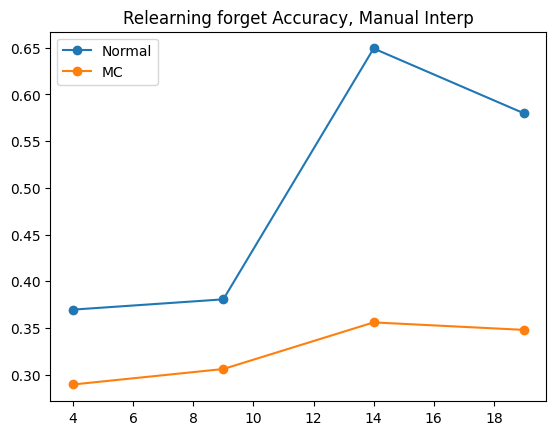

In [12]:
print(test_losses)
# plot
for task_name, task_split in [("Normal", "forget"), ("MC", "forget")]:
    x_vals = []
    y_vals = []
    for idx, point in enumerate(test_losses):
        if len(point) > 0:
            x_vals.append(idx)
            y_vals.append(point['adversarial'][task_name][task_split])
    plt.plot(x_vals, y_vals, label=task_name, marker="o")
plt.title(f"Relearning {task_split} Accuracy, Manual Interp")
plt.legend()
plt.show()

In [ ]:
localization_type = "manual_interp"
relearning_train_results[localization_type] = train_losses
relearning_test_results[localization_type] = test_losses

relearning_regular_results[localization_type] = {}
forget_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, **relearn_forget_kwargs)
maintain_sports_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, **relearn_maintain_kwargs)

for task_name, test_task in [("forget_sport", forget_sport_eval), ("maintain_sports", maintain_sports_eval)]:
    task_loss = 0
    task_accuracy = 0
    for i in range(n_eval_iters):
        task_loss += test_task.get_test_loss(model).item()
        task_accuracy += test_task.get_test_accuracy(model)
    relearning_regular_results[localization_type][f"{task_name}_ce"] = task_loss / n_eval_iters
    relearning_regular_results[localization_type][f"{task_name}_acc"] = task_accuracy / n_eval_iters

adversarial_eval_results = adversarial_sports_eval_redo(model, model_type="gemma", batch_size=eval_batch_size, 
                forget_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|relearn_forget_kwargs, 
                maintain_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|relearn_maintain_kwargs, 
                continuous=True, include_evals=["Normal", "MC"], inject_label=inject_label)
relearning_adversarial_results[localization_type] = adversarial_eval_results

side_effect_eval_results = run_side_effects_evals(model, model_type="gemma", batch_size=eval_batch_size, evals_to_run=["General"], general_batch_size=mmlu_batch_size)
relearning_side_effect_results[localization_type] = side_effect_eval_results


forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
forget_indices: range(0, 64)
forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
No injection, using original sports
forget_indices: range(0, 64)
No injection, using original sports
forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
No injection, using original sports
forget_indices: range(0, 64)
No injection, using original sports
forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
forget_indices: range(0, 64)
forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
forge

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
train_losses

defaultdict(list,
            {'relearn_athletes': [8.35687255859375,
              4.564327239990234,
              3.1119422912597656,
              2.0787923336029053,
              2.4106075763702393,
              0.6084827780723572,
              0.16075901687145233,
              0.1686170995235443,
              0.33432242274284363,
              0.18427033722400665],
             'maintain_athletes': [0.009097506292164326,
              4.95679235458374,
              3.8408188819885254,
              3.926440477371216,
              1.7907330989837646,
              1.0376237630844116,
              0.27969884872436523,
              0.25581055879592896,
              0.23600170016288757,
              0.0757896825671196],
             'pile': [2.1107261180877686,
              2.118854284286499,
              1.784339189529419,
              2.0353102684020996,
              2.7500758171081543,
              1.7041957378387451,
              2.6162643432617188,
             

In [13]:
test_losses

[{'MMLU': 0.55,
  'adversarial': {'Normal': {'forget': 0.4828683197498322,
    'maintain': 0.5657450973987579},
   'MC': {'forget': 0.627596116065979, 'maintain': 0.5481410026550293},
   'Normal_Injected': {'forget': 0.3081834614276886,
    'maintain': 0.16570953130722046},
   'MC_Injected': {'forget': 0.08634023219347,
    'maintain': 0.09484575241804125}}},
 {'MMLU': 0.57,
  'adversarial': {'Normal': {'forget': 0.3155366063117981,
    'maintain': 0.48944569826126105},
   'MC': {'forget': 0.575685465335846, 'maintain': 0.5736813008785249},
   'Normal_Injected': {'forget': 0.49889200925827026,
    'maintain': 0.21699928343296052},
   'MC_Injected': {'forget': 0.10108897984027863,
    'maintain': 0.09183327257633209}}},
 {'MMLU': 0.51,
  'adversarial': {'Normal': {'forget': 0.3608311891555786,
    'maintain': 0.2649928152561188},
   'MC': {'forget': 0.6469870209693909, 'maintain': 0.594197416305542},
   'Normal_Injected': {'forget': 0.3040452420711517,
    'maintain': 0.2622136950492859

### Probing

In [ ]:
model_path = "results_rebuttal/gemma_forget_64_inject_random_without_golf/localized_ct_run1/models/model.pt"
del model
print(torch.cuda.memory_allocated() / 10**9, "GB")

state_dict = torch.load(model_path)
# Convert state dict to bfloat16
# model.cpu()
state_dict = {k: v.to(torch.bfloat16) if isinstance(v, torch.Tensor) else v for k, v in state_dict.items()}
print(torch.cuda.memory_allocated() / 10**9, "GB")
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16)
model.load_state_dict(state_dict)
model.cuda()
print(torch.cuda.memory_allocated() / 10**9, "GB")

In [ ]:
# train probes on maintain split, and eval the forget split
maintain_kwargs = {"forget_split": "first_64_unsplit", "maintain_split": "split"}

maintain_sports_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, **maintain_kwargs)
train_df = maintain_sports_eval.train_df
probing_batch_size = 32

# want left sided tokenizer
tokenizer.padding_side = "left"

def retrieve_acts(model, tokenizer, prompt_list, batch_size, layer=None, to_cpu=False, truncate_length=None, seq_pos_list=None, stack_cache=True):
    """
    If seq_pos is not None, cache all the activations at the specified sequence position. Should be one list in seq_pos per prompt.
    """
    if layer is None or isinstance(layer, list):
        caches = defaultdict(list)
    else:
        caches = []
    for i in tqdm(range(0, len(prompt_list), batch_size)):
        tokenized_prompts = tokenizer(prompt_list[i:i+batch_size], return_tensors="pt", padding=True, truncation=True)
        prompt_toks = tokenized_prompts.input_ids
        attn_mask = tokenized_prompts.attention_mask
        if truncate_length is not None:
            if len(prompt_toks[0]) > truncate_length:
                print(f"Prompt {i} is too long, truncating")
                prompt_toks = prompt_toks[:, -truncate_length:]
                attn_mask = attn_mask[:, -truncate_length:]
        
        # if assert_end_newline:
        with torch.no_grad():
            model_output = model(
                input_ids=prompt_toks.cuda(),
                attention_mask=attn_mask.cuda(),
                output_hidden_states=True
            )
            hidden_states = model_output["hidden_states"]
        if isinstance(layer, list):
            for key_layer in layer:
                if to_cpu:
                    if seq_pos_list is not None:
                        for j in range(len(hidden_states[key_layer])):
                            caches[key_layer].append(hidden_states[key_layer][j, seq_pos_list[i+j], :].cpu())
                    else:
                        caches[key_layer].append(v[:, -1, :])
                else:
                    if seq_pos_list is not None:
                        for j in range(len(v)):
                            caches[key_layer].append(v[j, seq_pos_list[i+j], :])
                    else:
                        caches[key_layer].append(v[:, -1, :])

    print("Done caching")
    if stack_cache:
        if layer is None:
            for k, v in caches.items():
                if seq_pos_list is not None:
                    caches[k] = torch.stack(v, dim=0).cpu()
                else:
                    caches[k] = torch.cat(v, dim=0).cpu()
        else:
            if seq_pos_list is not None:
                caches = torch.stack(caches, dim=0).cpu()
            else:
                caches = torch.cat(caches, dim=0).cpu()
    return caches

all_acts = defaultdict(list)
labels = []
sport_idx = 0
for sport in train_df["sport"].unique():
    datapoints = train_df[train_df["sport"] == sport]
    print(sport, len(datapoints))
    
    prompts = datapoints["prompt"].tolist()

    acts = retrieve_acts(model, tokenizer, prompts, probing_batch_size, layer=list(range(28)), to_cpu=True)
    for layer in range(28):
        all_acts[layer].append(acts[layer])
    labels.append(torch.tensor([sport_idx]*len(acts)))
    sport_idx += 1

labels = torch.cat(labels, dim=0)
for layer in range(28):
    all_acts[layer] = torch.cat(all_acts[layer], dim=0)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Function to train and evaluate probes for each layer
def train_eval_probes(activations_dict, labels, test_size=0.2, random_state=42):
    results = {}
    
    for layer, acts in activations_dict.items():
        # Convert activations to numpy array if they're torch tensors
        X = acts.numpy() if hasattr(acts, 'numpy') else acts
        y = labels.numpy() if hasattr(labels, 'numpy') else labels
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
        
        # Initialize and train the probe
        probe = LogisticRegression(max_iter=1000, multi_class='multinomial')
        probe.fit(X_train, y_train)
        
        # Evaluate
        train_acc = accuracy_score(y_train, probe.predict(X_train))
        test_acc = accuracy_score(y_test, probe.predict(X_test))
        
        results[layer] = {
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'probe': probe
        }
        
        print(f"Layer {layer}:")
        print(f"Train accuracy: {train_acc:.4f}")
        print(f"Test accuracy: {test_acc:.4f}")
        print("Classification Report:")
        print(classification_report(y_test, probe.predict(X_test)))
        print("-" * 50)
    
    return results

# Train probes for all layers
probe_results = train_eval_probes(all_acts, labels)

# Plot the results
import matplotlib.pyplot as plt

layers = list(probe_results.keys())
train_accs = [results['train_accuracy'] for results in probe_results.values()]
test_accs = [results['test_accuracy'] for results in probe_results.values()]

plt.figure(figsize=(10, 6))
plt.plot(layers, train_accs, label='Train Accuracy')
plt.plot(layers, test_accs, label='Test Accuracy')
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.title('Probe Accuracy by Layer')
plt.legend()
plt.grid(True)
plt.show()

## CounterFact